In [1]:
import xarray as xr
import dask.array
import numpy as np
import pandas as pd
import os
import scipy.io
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as pcm
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.colors as col
import cmocean.cm as cm
import sys
sys.path.append('/home/Ruth.Moorman/')
import nclcmaps
import cv2

In [2]:
from matplotlib import rc, rcParams
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('axes', labelsize=15)

In [3]:
import sys
sys.path.append('/home/Ruth.Moorman/OM4p25_JRA55-do_simulations')
### import required python functions
from om4_tools import *
from ssh_contours import *

# OM4p25-BLING - annual

In [4]:
expdir = '/archive/Ruth.Moorman/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r'
umo_2d_C1 = get_iaf_variable(expdir, 1, 'ocean_annual', 'umo_2d')
umo_2d_C2 = get_iaf_variable(expdir, 2, 'ocean_annual', 'umo_2d')
umo_2d_C3 = get_iaf_variable(expdir, 3, 'ocean_annual', 'umo_2d')

In [5]:
static = xr.open_dataset(expdir+'/cycle1/ocean_static/20170101.ocean_static.nc')
bathy = static.deptho
land_mask = static.wet

(from cosima cookbook tutorial) 

Here we calculate the mean barotropic stream function by integrating the time-mean zonal transport in latitude starting from the South Pole. Therefore, for every $(x, y)$ point, the barotropic streamfunction $\psi$ is:

$$\psi(x, y) = -\int_{y_0}^y \frac{\overline{T^{x}(x, y')}}{\rho}\, \mathrm{d}y',$$
where $T^{x}(x, y)$ is the depth integrated mass transport, the overline denotes time-mean, $y_0$ is any arbirtrary latitude (in our case, the South Pole), and $\rho$ is the mean deansity of sea water (to convert mass transport to volume transport).

The minus sign above is merely a matter of convenction so that positive values of streamfunction denote eastward flow, the Southern subtropical gyre to corresponds to negative values, etc.

Variable umo_2d contains the instantaneous depth-intergrated zonal mass transport in the OM4 runs.

Finally, divide by mean $10^6$ to convect units from m$^3$/s to Sv.

Note that the streamfunction as defined above has a free parameter: we can subtract any constant we want. The way we defined $\psi$ above implies that $\psi$ is zeros in the South Pole.

A usual convention is to set the coast of South America to correspond to $ψ=0$. To do so, we the value on Patagonia and subtract it.

The value we need to subtract is found as the minimum value of $\psi$ in the longitude range [69W, 67W] south of 55S, $\psi_{ACC}$, which should be representative of the transport in the Drake Passage.

*(me)*

*This transport value is the southernmost continuous barotrpoic streamfunction we will be interested in. If a continuous contour may be constructed from this value, that is (sometimes an adjustment is needed).*

In [5]:
ρ = 1036 # kg/m^3
psi_C1 = -umo_2d_C1.mean('time').cumsum('yh')/(1e6*ρ) # divide by 1e6 to convert m^3/s

In [6]:
psi_acc_C1 = np.nanmin(psi_C1.sel(xq = slice(-69, -67), yh = slice(-80, -55)))
print('Max value of streamfunction south of 55S and within 69W-67W = ', -psi_acc_C1, 'Sv')


Max value of streamfunction south of 55S and within 69W-67W =  140.83208 Sv


In [7]:
psi_g_C1 = psi_C1-psi_acc_C1
psi_g_C1 = psi_g_C1.rename('Barotropic Stream function')
psi_g_C1.attrs['long_name'] = 'Barotropic Stream function'
psi_g_C1.attrs['units'] = 'Sv'

In [8]:
def so_basics(ax, land_mask=land_mask, lat_north = -29, grid = True):
    ax.contour(land_mask.sel(yh = slice(-90,lat_north)).xh, land_mask.sel(yh = slice(-90,lat_north)).yh,land_mask.sel(yh = slice(-90,lat_north)),[0,1], colors = 'k', alpha = 1, transform=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, lat_north], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    if grid == True:
        gl = ax.gridlines(linewidth = 1, color = 'grey', linestyle = '--', alpha = 0.7)
        gl.ylocator = mticker.FixedLocator([-90,-80,-70, -60, -50, -40, -30])

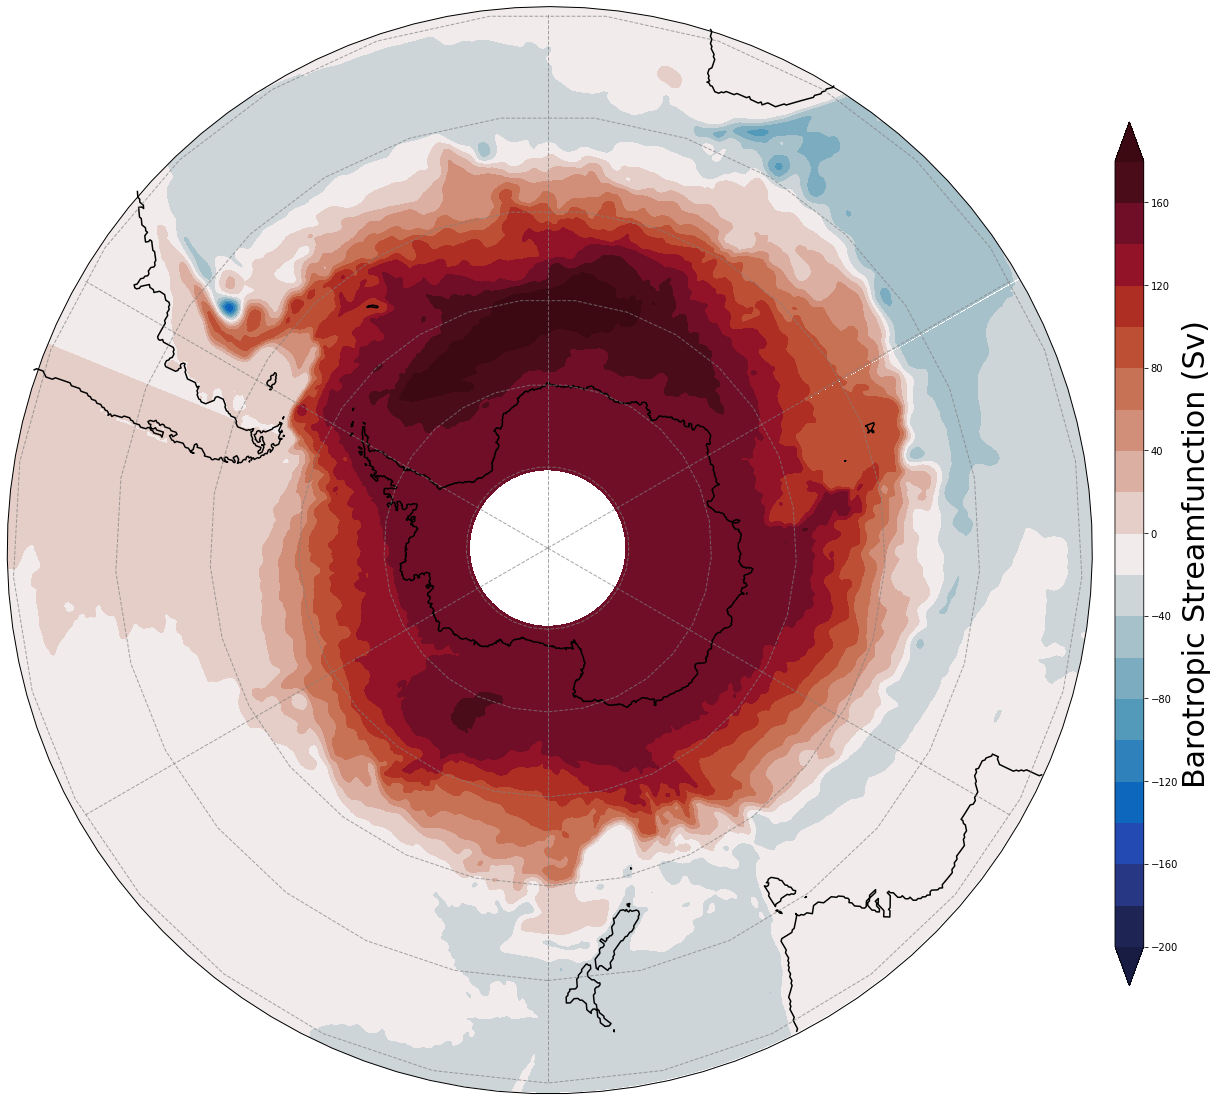

In [9]:
fig = plt.figure(figsize=[20, 20])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -29
so_basics(ax,land_mask,lat_north = -29)

lvls = np.arange(-200, 200, 20)
cf = ax.contourf(psi_g_C1.xq, psi_g_C1.yh, psi_g_C1, levels = lvls, cmap = cm.balance, extend = 'both', transform = ccrs.PlateCarree())

cax = fig.add_axes([0.905, 0.2, 0.02, 0.6])
cbar=plt.colorbar(cf,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel('Barotropic Streamfunction (Sv)', fontsize = 30)

plt.show()

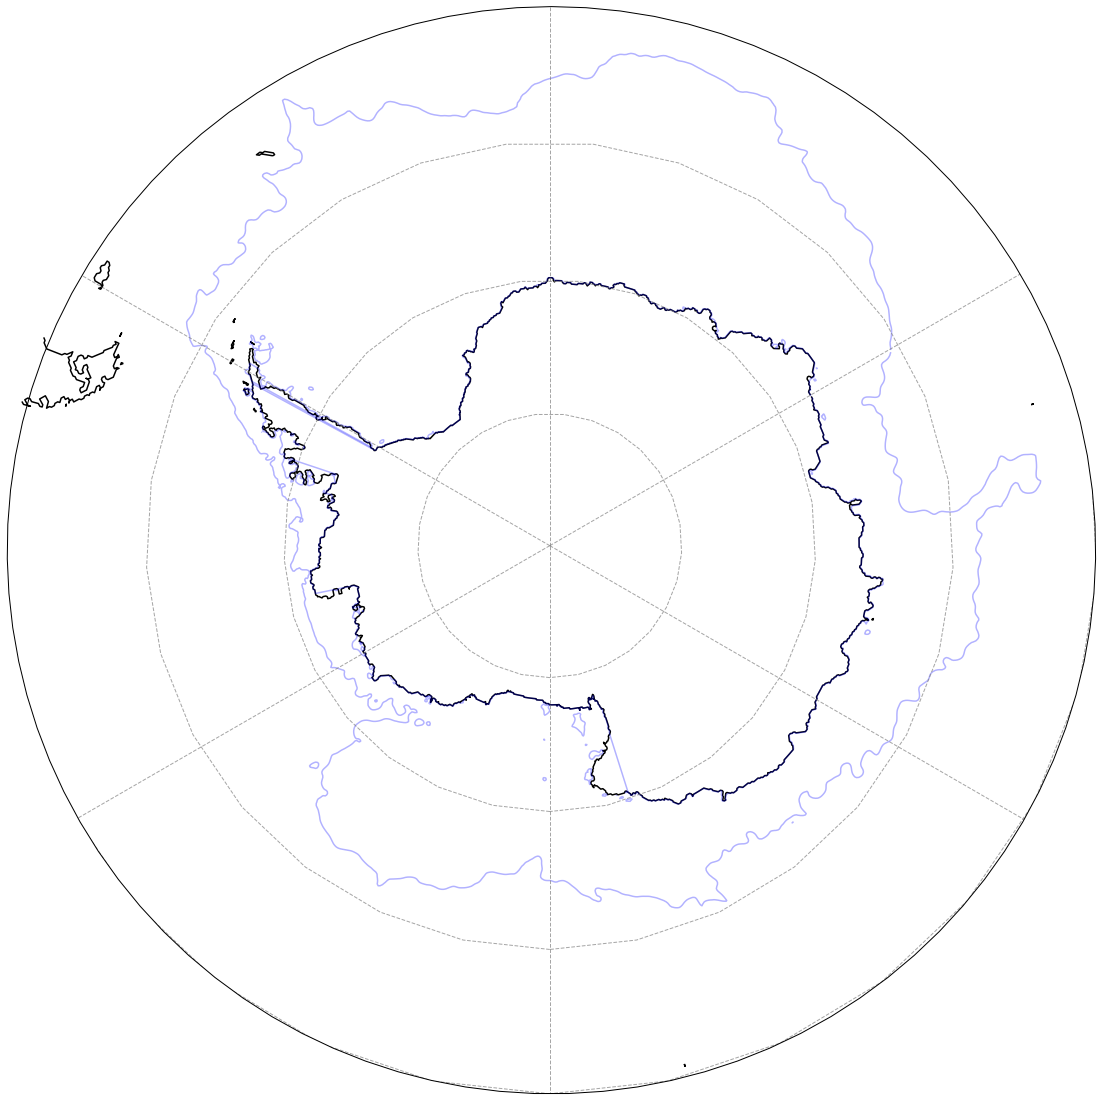

In [10]:
fig = plt.figure(figsize=[20, 20])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50)

lvls = np.arange(130, 150, 1)
ax.contour(psi_g_C1.xq, psi_g_C1.yh, psi_g_C1, levels = np.array([-psi_acc_C1]), colors = 'b', alpha = 0.3, transform = ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
# ax.gridlines(color='grey', linestyle='--')

plt.show()

In [78]:
# let's try and find the southernmost circumpolar barotrpioc streamfunction?
#3 same method as for the ssh contour
# want to see how closely these align

In [122]:
def OM4_ACCS_psig_contour(umo_2D,lat_north = -29):
    ρ = 1036 # kg/m^3
    psi = -umo_2D.cumsum('yh')/(1e6*ρ) # divide by 1e6 to convert m^3/s
    psi_acc = np.nanmin(psi.sel(xq = slice(-69, -67), yh = slice(-80, -55)))
    print('Max value of streamfunction south of 55S and within 69W-67W (ACC transport) = ', -psi_acc, 'Sv')
    psi_g = psi-psi_acc
    psi_g = psi_g.rename('Barotropic Stream function')
    psi_g.attrs['long_name'] = 'Barotropic Stream function'
    psi_g.attrs['units'] = 'Sv'
    
    adjust = 0
    for k in range(10):
        
        contour = -psi_acc-(adjust * 0.1)
        temp = psi_g.where(psi_g>=contour) * 0 + 1
        temp_mask = psi_g.copy().fillna(1)
        xh = temp_mask.xq
        yh = temp_mask.yh
        temp_mask = temp_mask.where(temp_mask >= contour) * 0 + 1
        temp_mask = temp_mask.fillna(0)
        temp_mask = temp_mask.values # extract numpy file
        # # this spreads the isobath contour so all points are connected adjacently (not just 
        # # diagonally):

        kernel = np.ones((3,3),np.uint8)
        contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask
        # start at western edge of domain, at y point closest to correct depth contour:
        contour_mask = np.zeros_like(temp_mask) 
        contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][-1]
        contour_mask[contour_lat_index_start,0] = 1
        # loop through to find adjacent point closest to contour depth (not inc previous point):
        last_index_i = np.array([0])
        last_index_j = contour_lat_index_start
        count = np.array([0])


        while last_index_i<(len(xh)-1): # 1440 is xh dimension length
            # first time don't go backwards:
            if last_index_i == 0:
                points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                    0,
                    contour_mask0[last_index_j+1,last_index_i],
                    contour_mask0[last_index_j-1,last_index_i]])
            else:
                points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                    contour_mask0[last_index_j,last_index_i-1],
                    contour_mask0[last_index_j+1,last_index_i],
                    contour_mask0[last_index_j-1,last_index_i]])
            new_loc = np.where(points_to_compare==1)[0]
            # this gives each point along contour a unique index number:
            if len(new_loc)==0:
                contour_mask0[last_index_j,last_index_i] = 0
                count = count - 1
                last_index_i = np.where(contour_mask==count+1)[1]
                last_index_j = np.where(contour_mask==count+1)[0]
                if len(last_index_i)>1:
                    last_index_i = last_index_i[0]
                    last_index_j = last_index_j[0]
                else:
                    continue
            elif len(new_loc)>0:
                if new_loc[0] == 0:
                    new_index_i = last_index_i+1
                    new_index_j = last_index_j
                elif new_loc[0] == 1:
                    new_index_i = last_index_i-1
                    new_index_j = last_index_j
                elif new_loc[0] == 2:
                    new_index_i = last_index_i
                    new_index_j = last_index_j+1            
                elif new_loc[0] == 3:
                    new_index_i = last_index_i
                    new_index_j = last_index_j-1

                contour_mask[new_index_j,new_index_i] = count + 2
                contour_mask0[last_index_j,last_index_i] = 2
                last_index_j = new_index_j
                last_index_i = new_index_i
                count += 1
                if len(np.array([last_index_i])) >1:
                    last_index_i = last_index_i[0]
                    last_index_j = last_index_j[0]
        if np.sum(contour_mask, axis = 0).min() == 1:
            # sometimes the contour fitting algorithm falls onto the land mask edge and stays there, erroneously resulting in a circumpolar continuous contour. Add the constraint that the final index does not coincide with land (seems to be enough).
#             print('adjusted:',adjust)
            break
        else:
            adjust += 1 
    # # this is the sequentially numbered isobath, it provides an along isobath index
    contour_mask_numbered = contour_mask
    # sometimes there's a discontinuoity at 0
    if last_index_j > contour_lat_index_start:
        a = 0
        for m in np.arange(last_index_j,contour_lat_index_start-1, -1):
            contour_mask_numbered[m,-1] = contour_mask_numbered[last_index_j,-1] +a
            a += 1
    elif last_index_j < contour_lat_index_start:
        a = 0
        for m in np.arange(last_index_j, contour_lat_index_start+1, 1):
            contour_mask_numbered[m,-1] = contour_mask_numbered[last_index_j,-1] +a
            a += 1
    # fill in points to north of contour:
    contour_masked_above = np.copy(contour_mask_numbered)
    contour_masked_above[-1,0] = -100

    # from top left:
    for ii in range(len(xh)-1):
        for jj in range(len(yh))[::-1][:-1]:
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj-1,ii] == 0:
                    contour_masked_above[jj-1,ii] = -100
                if contour_masked_above[jj,ii+1] == 0:
                    contour_masked_above[jj,ii+1] = -100
                if contour_masked_above[jj-1,ii+1] == 0:
                    contour_masked_above[jj-1,ii+1] = -100
    # from top right:
    for ii in range(len(xh))[::-1][:-1]:
        for jj in range(len(yh))[::-1][:-1]:
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj-1,ii] == 0:
                    contour_masked_above[jj-1,ii] = -100
                if contour_masked_above[jj,ii-1] == 0:
                    contour_masked_above[jj,ii-1] = -100
                if contour_masked_above[jj-1,ii-1] == 0:
                    contour_masked_above[jj-1,ii-1] = -100
    # from bottom right:
    for ii in range(len(xh))[::-1][:-1]:
        for jj in range(len(yh)-1):
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj+1,ii] == 0:
                    contour_masked_above[jj+1,ii] = -100
                if contour_masked_above[jj,ii-1] == 0:
                    contour_masked_above[jj,ii-1] = -100
                if contour_masked_above[jj+1,ii-1] == 0:
                    contour_masked_above[jj+1,ii-1] = -100
    # from bottom left:
    for ii in range(len(xh)-1):
        for jj in range(len(yh)-1):
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj+1,ii] == 0:
                    contour_masked_above[jj+1,ii] = -100
                if contour_masked_above[jj,ii+1] == 0:
                    contour_masked_above[jj,ii+1] = -100
                if contour_masked_above[jj+1,ii+1] == 0:
                    contour_masked_above[jj+1,ii+1] = -100
    contour_mask_numbered = xr.DataArray(contour_mask_numbered, coords = [yh, xh], dims = ['yh', 'xq'])
    contour_masked_south = xr.DataArray(contour_masked_above, coords = [yh, xh], dims = ['yh', 'xq'])
    contour_masked_south = contour_masked_south.where(contour_masked_south >= 0) * 0 + 1 
    
    return contour_mask_numbered, contour_masked_south, -psi_acc, contour

In [29]:
# initate empty for masks
empty = np.empty((60,382,1440))
empty[:,:,:] = np.nan
accpsi_mask_c1_annual = xr.DataArray(empty, coords = umo_2d_C1.coords)
accpsi_mask_c1_annual.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
accpsi_mask_c1_annual.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
accpsi_mask_c1_annual.attrs['time_avg_info'] = 'annual mean umo_2D used'
# initate empty for numbers (in case later you want to do the index thing, might as well compute once)
empty = np.empty((60,382,1440))
empty[:,:,:] = np.nan
accpsi_numbers_c1_annual = xr.DataArray(empty, coords = umo_2d_C1.coords)
accpsi_numbers_c1_annual.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous barotropic streamfunction contour'
accpsi_numbers_c1_annual.attrs['time_avg_info'] = 'annual mean umo_2D used'
# intiate empty for ssh value at contour
empty = np.empty((60))
empty[:] = np.nan
accpsi_contour_value = xr.DataArray(empty, coords = [umo_2d_C1.time], dims = 'time')
accpsi_value = xr.DataArray(empty, coords = [umo_2d_C1.time], dims = 'time')

In [30]:
%%time
for y in range(60):
    print(y)
    contour_numbered, contour_mask, psi_acc, contour = OM4_ACCS_psig_contour(umo_2d_C1.isel(time = y),lat_north = -29)
    accpsi_mask_c1_annual[y,:,:] = contour_mask.values
    accpsi_numbers_c1_annual[y,:,:] = contour_numbered.values
    accpsi_contour_value[y] = contour
    accpsi_value[y] = psi_acc

0
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  147.78107 Sv
1
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  145.78058 Sv
2
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  142.02696 Sv
3
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  139.41682 Sv
4
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  139.07848 Sv
5
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  140.22762 Sv
6
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  135.27855 Sv
7
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  136.66838 Sv
8
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  133.75859 Sv
9
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  130.91193 Sv
10
Max value of streamfunction south of 55S and within 69W-6

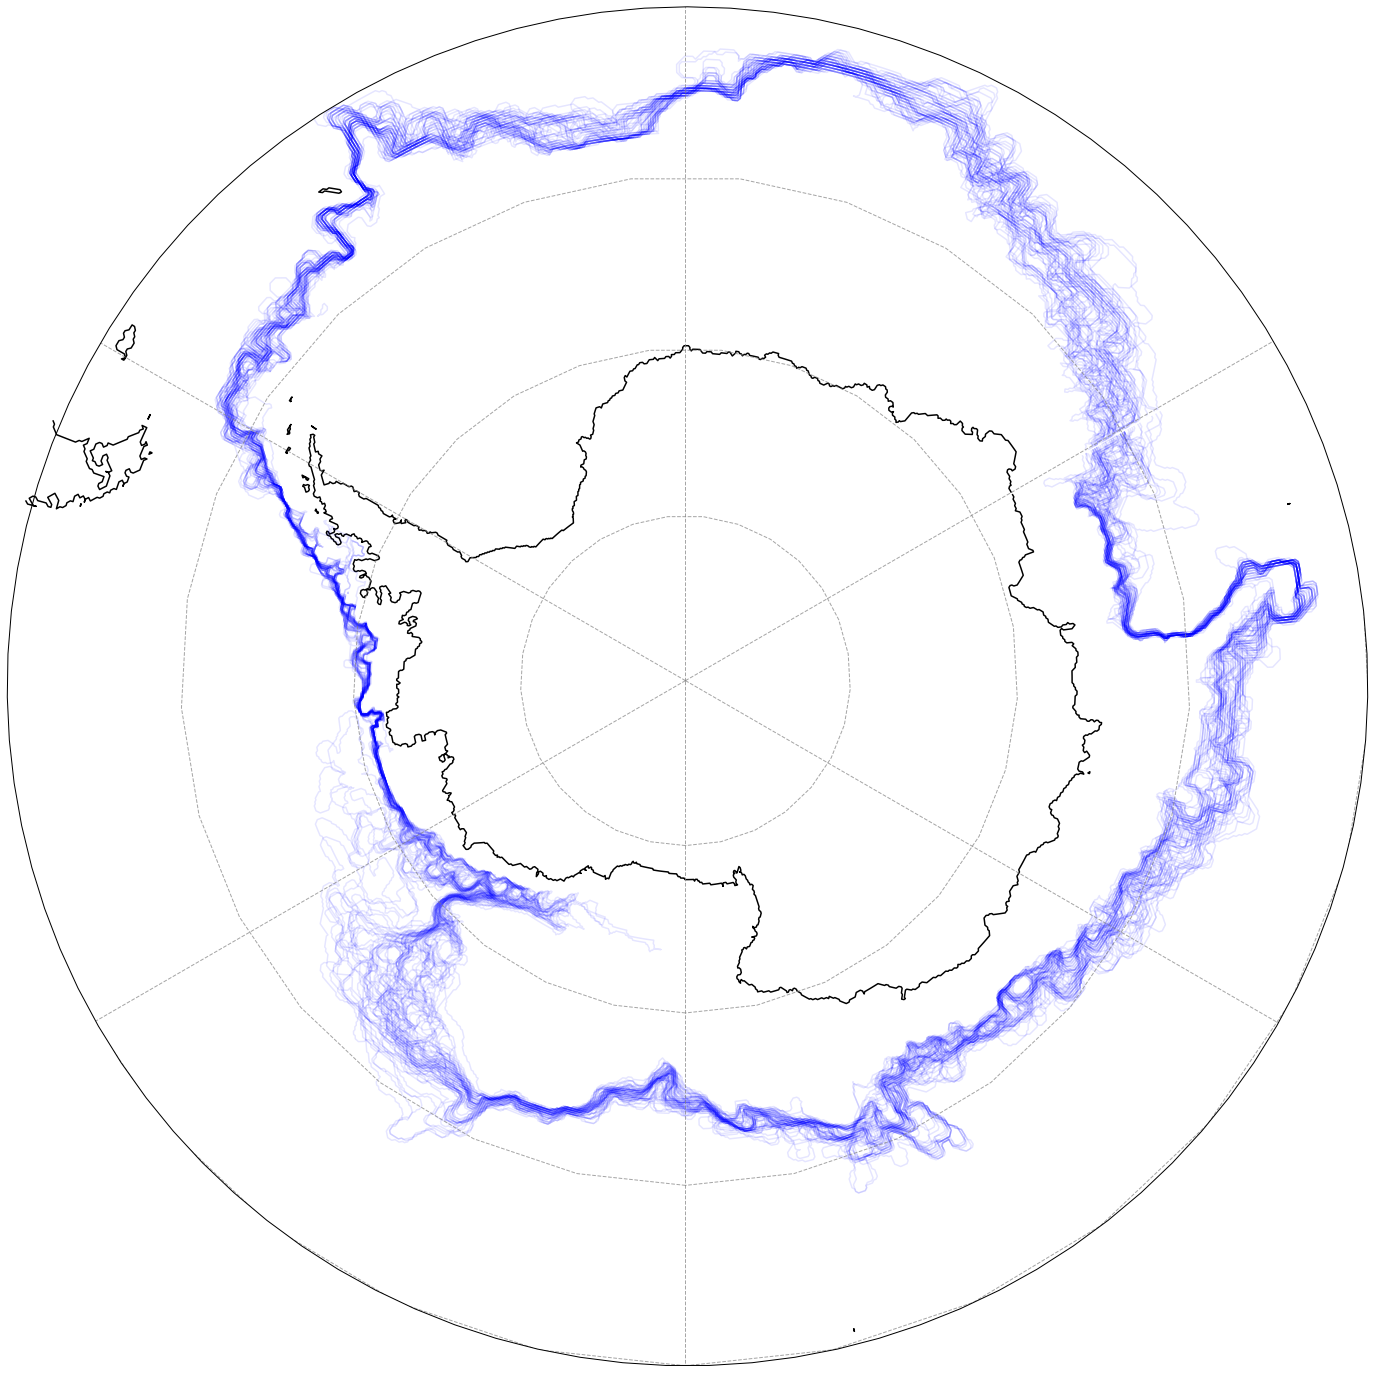

In [32]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50)
for i in range(60):
    ax.contour(accpsi_mask_c1_annual.isel(time = i).xq, accpsi_mask_c1_annual.isel(time = i).yh,accpsi_mask_c1_annual.isel(time = i).fillna(0), levels = [0,1], colors = 'b', alpha = 0.1, transform = ccrs.PlateCarree())
plt.show()

In [35]:
accpsi_numbers_c1_annual.attrs['description'] = 'Southernmost continous circumpolar barotropic streamfunction contour(i.e. southern ACC boundary) (value in accpsi_contour_value coord). Points on the contour are numbered sequentially, providing an along-contour index.'
accpsi_mask_c1_annual.attrs['description'] = 'Masks for the region south of the southernmost continous circumpolar barotropic streamfunction contour(i.e. southern ACC boundary) (value in accpsi_contour_value coord). Gridpoints on and polewards of the contour are 1, points equatorward of the contour are nan.'
accpsi_numbers_c1_annual = xr.DataArray(accpsi_numbers_c1_annual, coords = {'time':accpsi_numbers_c1_annual.time, 'yh':accpsi_numbers_c1_annual.yh, 'xq':accpsi_numbers_c1_annual.xq, 'accpsi_contour_value': accpsi_contour_value, 'drake_passage_transport': accpsi_value}, attrs = accpsi_numbers_c1_annual.attrs)
accpsi_mask_c1_annual = xr.DataArray(accpsi_mask_c1_annual, coords = {'time':accpsi_mask_c1_annual.time, 'yh':accpsi_mask_c1_annual.yh, 'xq':accpsi_mask_c1_annual.xq, 'accpsi_contour_value': accpsi_contour_value, 'drake_passage_transport':accpsi_value }, attrs = accpsi_mask_c1_annual.attrs)
ds = xr.Dataset({'contour_mask_numbered':accpsi_numbers_c1_annual, 'contour_masked_south':accpsi_mask_c1_annual})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle1_1959-2017_annual_ACC_PSI_contour.nc')

In [44]:
# initate empty for masks
empty = np.empty((60,382,1440))
empty[:,:,:] = np.nan
accpsi_mask_c2_annual = xr.DataArray(empty, coords = umo_2d_C2.coords)
accpsi_mask_c2_annual.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
accpsi_mask_c2_annual.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
accpsi_mask_c2_annual.attrs['time_avg_info'] = 'annual mean umo_2D used'
# initate empty for numbers (in case later you want to do the index thing, might as well compute once)
empty = np.empty((60,382,1440))
empty[:,:,:] = np.nan
accpsi_numbers_c2_annual = xr.DataArray(empty, coords = umo_2d_C2.coords)
accpsi_numbers_c2_annual.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous barotropic streamfunction contour'
accpsi_numbers_c2_annual.attrs['time_avg_info'] = 'annual mean umo_2D used'
# intiate empty for ssh value at contour
empty = np.empty((60))
empty[:] = np.nan
accpsi_contour_value = xr.DataArray(empty, coords = [umo_2d_C2.time], dims = 'time')
accpsi_value = xr.DataArray(empty, coords = [umo_2d_C2.time], dims = 'time')

In [45]:
%%time
for y in range(60):
    print(y)
    contour_numbered, contour_mask, psi_acc, contour = OM4_ACCS_psig_contour(umo_2d_C2.isel(time = y),lat_north = -29)
    accpsi_mask_c2_annual[y,:,:] = contour_mask.values
    accpsi_numbers_c2_annual[y,:,:] = contour_numbered.values
    accpsi_contour_value[y] = contour
    accpsi_value[y] = psi_acc

0
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  140.05896 Sv
1
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  143.05843 Sv
2
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  146.85739 Sv
3
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  143.41187 Sv
4
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  144.83514 Sv
5
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  148.11497 Sv
6
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  146.14632 Sv
7
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  142.1954 Sv
8
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  142.44693 Sv
9
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  141.95195 Sv
10
Max value of streamfunction south of 55S and within 69W-67

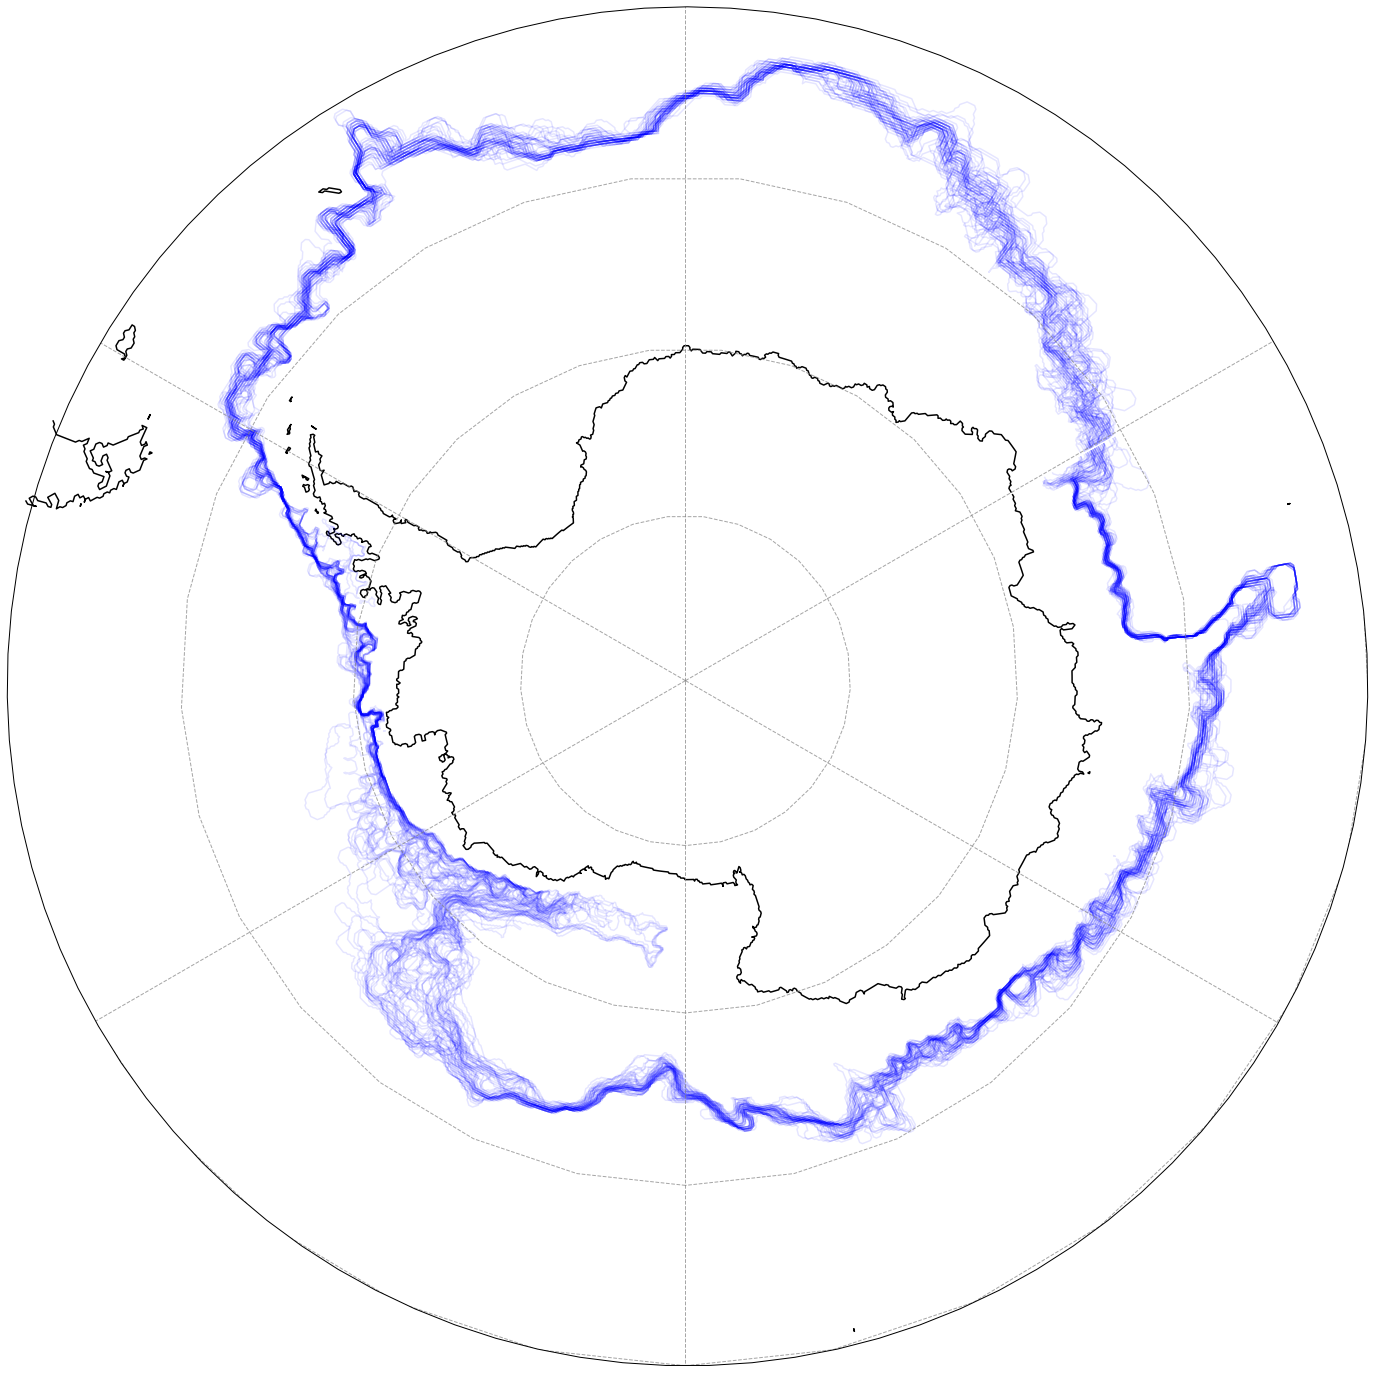

In [46]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50)
for i in range(60):
    ax.contour(accpsi_mask_c2_annual.isel(time = i).xq, accpsi_mask_c2_annual.isel(time = i).yh,accpsi_mask_c2_annual.isel(time = i).fillna(0), levels = [0,1], colors = 'b', alpha = 0.1, transform = ccrs.PlateCarree())
plt.show()

In [48]:
accpsi_numbers_c2_annual.attrs['description'] = 'Southernmost continous circumpolar barotropic streamfunction contour(i.e. southern ACC boundary) (value in accpsi_contour_value coord). Points on the contour are numbered sequentially, providing an along-contour index.'
accpsi_mask_c2_annual.attrs['description'] = 'Masks for the region south of the southernmost continous circumpolar barotropic streamfunction contour(i.e. southern ACC boundary) (value in accpsi_contour_value coord). Gridpoints on and polewards of the contour are 1, points equatorward of the contour are nan.'
accpsi_numbers_c2_annual = xr.DataArray(accpsi_numbers_c2_annual, coords = {'time':accpsi_numbers_c2_annual.time, 'yh':accpsi_numbers_c2_annual.yh, 'xq':accpsi_numbers_c2_annual.xq, 'accpsi_contour_value': accpsi_contour_value, 'drake_passage_transport': accpsi_value}, attrs = accpsi_numbers_c2_annual.attrs)
accpsi_mask_c2_annual = xr.DataArray(accpsi_mask_c2_annual, coords = {'time':accpsi_mask_c2_annual.time, 'yh':accpsi_mask_c2_annual.yh, 'xq':accpsi_mask_c2_annual.xq, 'accpsi_contour_value': accpsi_contour_value, 'drake_passage_transport':accpsi_value }, attrs = accpsi_mask_c2_annual.attrs)
ds = xr.Dataset({'contour_mask_numbered':accpsi_numbers_c2_annual, 'contour_masked_south':accpsi_mask_c2_annual})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle2_1959-2017_annual_ACC_PSI_contour.nc')

In [52]:
# initate empty for masks
empty = np.empty((59,382,1440))
empty[:,:,:] = np.nan
accpsi_mask_c3_annual = xr.DataArray(empty, coords = umo_2d_C3.coords)
accpsi_mask_c3_annual.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
accpsi_mask_c3_annual.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
accpsi_mask_c3_annual.attrs['time_avg_info'] = 'annual mean umo_2D used'
# initate empty for numbers (in case later you want to do the index thing, might as well compute once)
empty = np.empty((59,382,1440))
empty[:,:,:] = np.nan
accpsi_numbers_c3_annual = xr.DataArray(empty, coords = umo_2d_C3.coords)
accpsi_numbers_c3_annual.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous barotropic streamfunction contour'
accpsi_numbers_c3_annual.attrs['time_avg_info'] = 'annual mean umo_2D used'
# intiate empty for ssh value at contour
empty = np.empty((59))
empty[:] = np.nan
accpsi_contour_value = xr.DataArray(empty, coords = [umo_2d_C3.time], dims = 'time')
accpsi_value = xr.DataArray(empty, coords = [umo_2d_C3.time], dims = 'time')

In [53]:
%%time
for y in range(59):
    print(y)
    contour_numbered, contour_mask, psi_acc, contour = OM4_ACCS_psig_contour(umo_2d_C3.isel(time = y),lat_north = -29)
    accpsi_mask_c3_annual[y,:,:] = contour_mask.values
    accpsi_numbers_c3_annual[y,:,:] = contour_numbered.values
    accpsi_contour_value[y] = contour
    accpsi_value[y] = psi_acc

0
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  145.74405 Sv
1
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  147.97005 Sv
2
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  148.26884 Sv
3
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  147.60165 Sv
4
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  150.3853 Sv
5
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  151.18982 Sv
6
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  148.70569 Sv
7
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  150.03185 Sv
8
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  147.27855 Sv
9
Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  145.66634 Sv
10
Max value of streamfunction south of 55S and within 69W-67

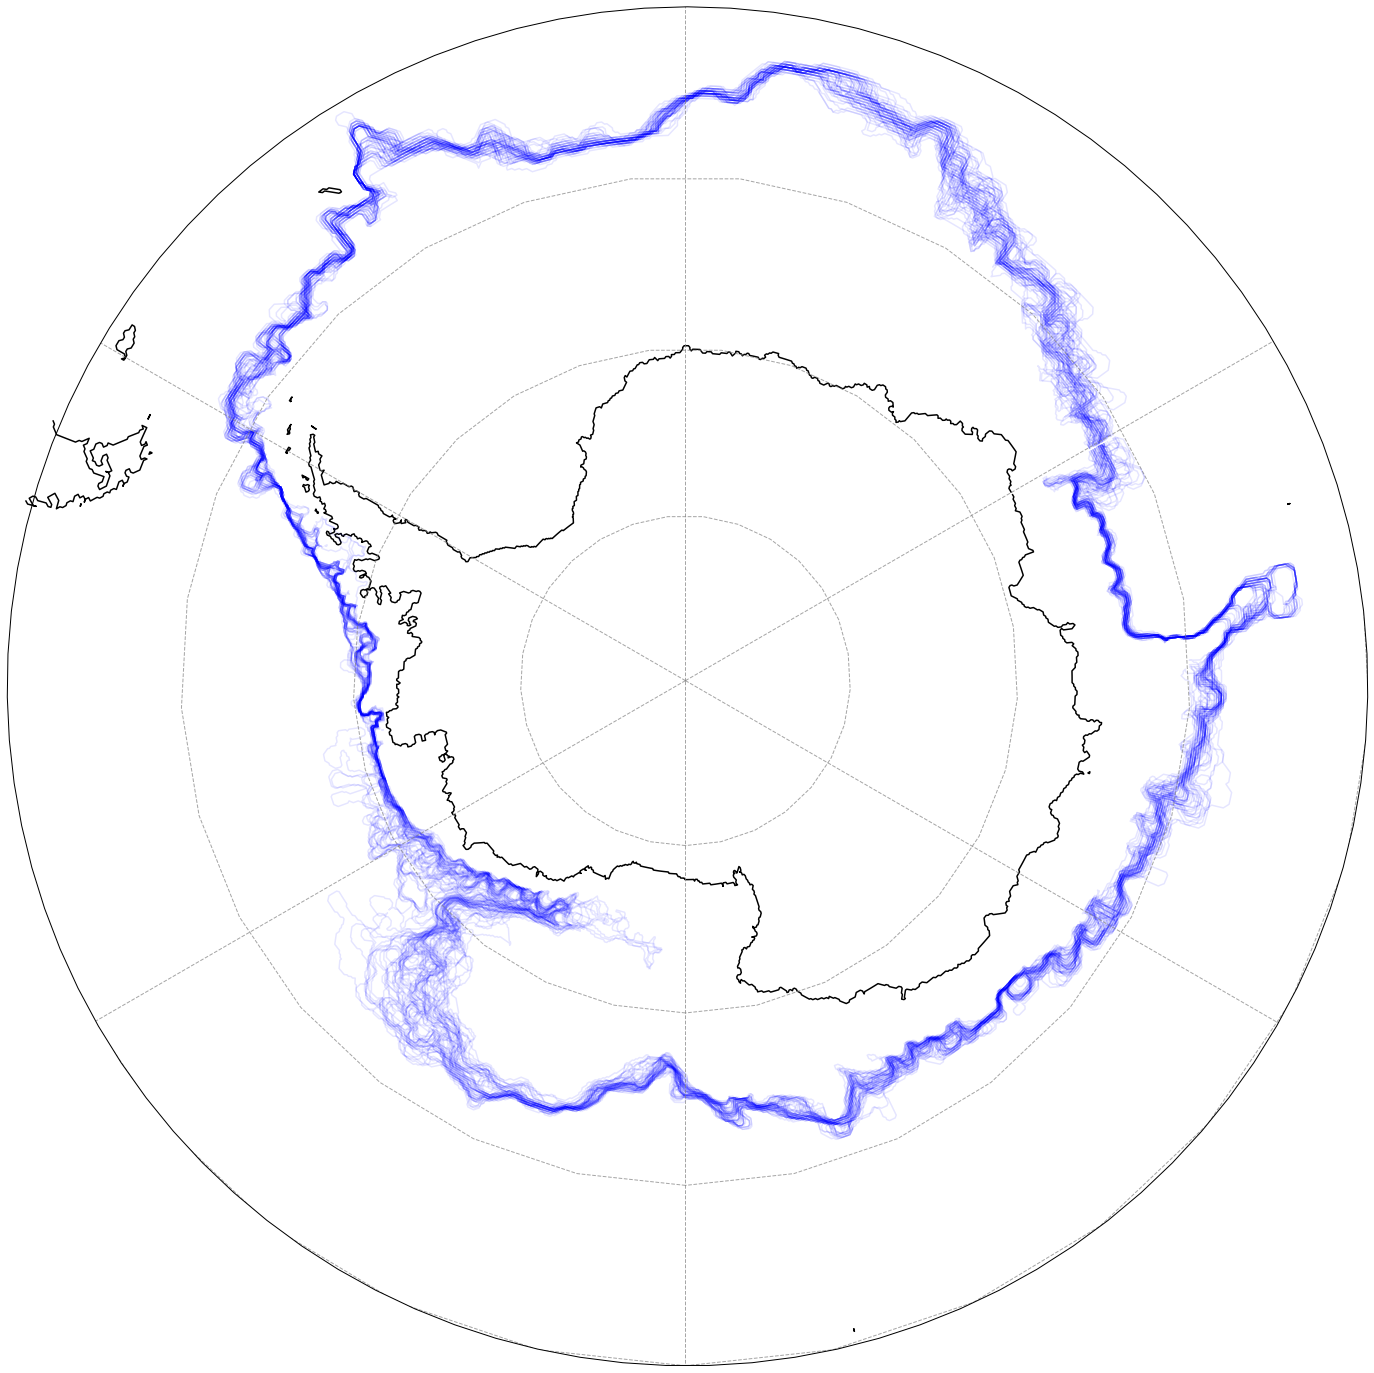

In [105]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50)
for i in range(59):
    ax.contour(accpsi_mask_c3_annual.isel(time = i).xq, accpsi_mask_c3_annual.isel(time = i).yh,accpsi_mask_c3_annual.isel(time = i).fillna(0), levels = [0,1], colors = 'b', alpha = 0.1, transform = ccrs.PlateCarree())
plt.show()

In [55]:
accpsi_numbers_c3_annual.attrs['description'] = 'Southernmost continous circumpolar barotropic streamfunction contour(i.e. southern ACC boundary) (value in accpsi_contour_value coord). Points on the contour are numbered sequentially, providing an along-contour index.'
accpsi_mask_c3_annual.attrs['description'] = 'Masks for the region south of the southernmost continous circumpolar barotropic streamfunction contour(i.e. southern ACC boundary) (value in accpsi_contour_value coord). Gridpoints on and polewards of the contour are 1, points equatorward of the contour are nan.'
accpsi_numbers_c3_annual = xr.DataArray(accpsi_numbers_c3_annual, coords = {'time':accpsi_numbers_c3_annual.time, 'yh':accpsi_numbers_c3_annual.yh, 'xq':accpsi_numbers_c3_annual.xq, 'accpsi_contour_value': accpsi_contour_value, 'drake_passage_transport': accpsi_value}, attrs = accpsi_numbers_c3_annual.attrs)
accpsi_mask_c3_annual = xr.DataArray(accpsi_mask_c3_annual, coords = {'time':accpsi_mask_c3_annual.time, 'yh':accpsi_mask_c3_annual.yh, 'xq':accpsi_mask_c3_annual.xq, 'accpsi_contour_value': accpsi_contour_value, 'drake_passage_transport':accpsi_value }, attrs = accpsi_mask_c3_annual.attrs)
ds = xr.Dataset({'contour_mask_numbered':accpsi_numbers_c3_annual, 'contour_masked_south':accpsi_mask_c3_annual})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle3_1959-2017_annual_ACC_PSI_contour.nc')

Are the three cycles very different?

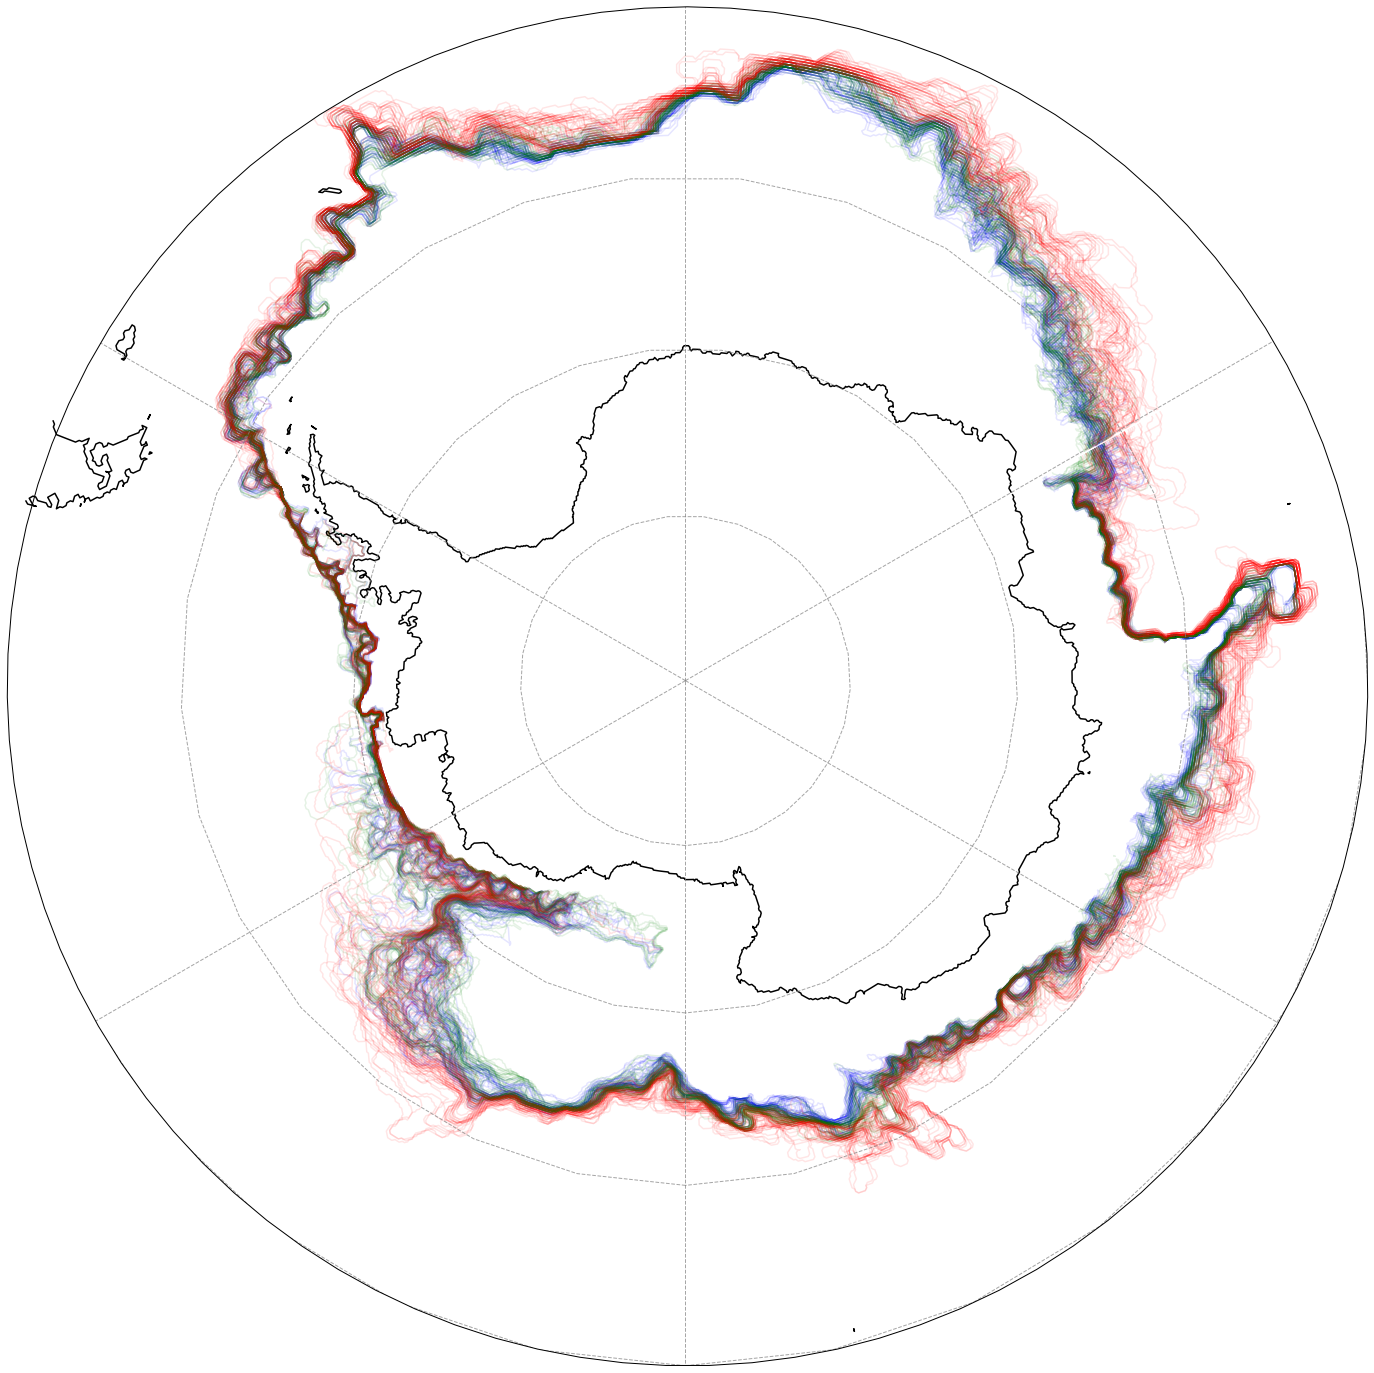

In [106]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50)
for i in range(59):
    ax.contour(accpsi_mask_c3_annual.isel(time = i).xq, accpsi_mask_c3_annual.isel(time = i).yh,accpsi_mask_c3_annual.isel(time = i).fillna(0), levels = [0,1], colors = 'b', alpha = 0.1, transform = ccrs.PlateCarree())
for i in range(60):
    ax.contour(accpsi_mask_c1_annual.isel(time = i).xq, accpsi_mask_c1_annual.isel(time = i).yh,accpsi_mask_c1_annual.isel(time = i).fillna(0), levels = [0,1], colors = 'r', alpha = 0.1, transform = ccrs.PlateCarree())
    ax.contour(accpsi_mask_c2_annual.isel(time = i).xq, accpsi_mask_c2_annual.isel(time = i).yh,accpsi_mask_c2_annual.isel(time = i).fillna(0), levels = [0,1], colors = 'g', alpha = 0.1, transform = ccrs.PlateCarree())
plt.show()

In [70]:
#timeseries of drake passage transport
DPT_c3 = accpsi_mask_c3_annual.drake_passage_transport.groupby('time.year').mean()
DPT_c2 = accpsi_mask_c2_annual.drake_passage_transport.groupby('time.year').mean()
DPT_c1 = accpsi_mask_c1_annual.drake_passage_transport.groupby('time.year').mean()

In [74]:
DPT_c2.coords['year'] = DPT_c2.year + 60
DPT_c3.coords['year'] = DPT_c3.year + 120

In [78]:
DPT_all = xr.concat((DPT_c1, DPT_c2, DPT_c3), dim = 'year')

In [79]:
DPT_all

<xarray.DataArray 'drake_passage_transport' (year: 179)>
array([147.78106689, 145.78057861, 142.02696228, 139.41682434,
       139.07847595, 140.22761536, 135.27854919, 136.66838074,
       133.7585907 , 130.91192627, 135.51855469, 133.26399231,
       133.05943298, 135.87782288, 134.57232666, 138.0846405 ,
       139.03862   , 138.22073364, 140.2137146 , 142.21749878,
       138.6499176 , 139.80262756, 137.79425049, 136.57620239,
       141.33062744, 140.09663391, 138.57843018, 136.76594543,
       135.33638   , 138.66584778, 137.58509827, 142.07722473,
       140.70153809, 141.08369446, 140.21246338, 147.55433655,
       143.54637146, 144.324646  , 142.77328491, 143.08378601,
       144.98068237, 144.53921509, 150.02006531, 144.99598694,
       145.22972107, 144.31167603, 155.44876099, 142.69981384,
       142.70463562, 144.0806427 , 144.08706665, 145.25360107,
       145.75395203, 162.81739807, 145.21989441, 144.9440155 ,
       146.6532135 , 148.89666748, 147.61543274, 147.95835876,
       140.05895996, 143.0584259 , 146.85739136, 143.41186523,
       144.83514404, 148.11497498, 146.14631653, 142.19540405,
       142.44692993, 141.95195007, 149.17030334, 145.19496155,
       159.96633911, 145.48643494, 144.54975891, 149.10197449,
       148.08654785, 150.81788635, 153.85488892, 150.62901306,
       148.7381134 , 149.72271729, 150.72497559, 156.41893005,
       153.9440918 , 151.80368042, 147.66830444, 151.83013916,
       151.01176453, 148.78599548, 147.49891663, 154.97671509,
       151.37020874, 150.26046753, 150.46922302, 154.65634155,
       150.63418579, 151.20326233, 148.18003845, 151.98535156,
       154.41567993, 152.71446228, 149.92683411, 154.36555481,
       154.36151123, 149.26457214, 150.79943848, 152.24787903,
       150.79377747, 149.31387329, 150.96003723, 147.84336853,
       149.31898499, 151.4876709 , 152.64472961, 149.00369263,
       151.47238159, 153.31947327, 152.25219727, 152.11012268,
       145.74404907, 147.970047  , 148.2688446 , 147.60165405,
       150.38529968, 151.18981934, 148.70568848, 150.03184509,
       147.27854919, 145.66633606, 154.10945129, 148.95118713,
       147.40737915, 145.65048218, 149.03216553, 150.60986328,
       147.75682068, 150.89598083, 154.43780518, 151.95333862,
       154.83708191, 155.32063293, 152.98573303, 153.23414612,
       152.69343567, 152.24069214, 154.918396  , 153.63406372,
       151.48878479, 150.80932617, 154.54795837, 150.88452148,
       152.61070251, 150.97766113, 159.05021667, 150.42578125,
       152.88877869, 150.57104492, 151.88609314, 152.36218262,
       152.10519409, 151.18768311, 163.39486694, 147.92720032,
       151.3085022 , 152.75653076, 152.17619324, 151.54370117,
       149.52362061, 150.04759216, 149.83280945, 149.11419678,
       165.0663147 , 150.98854065, 160.83732605, 149.08792114,
       154.23858643, 154.20722961, 151.70422363])
Coordinates:
  * year     (year) int64 1958 1959 1960 1961 1962 ... 2133 2134 2135 2136 2137

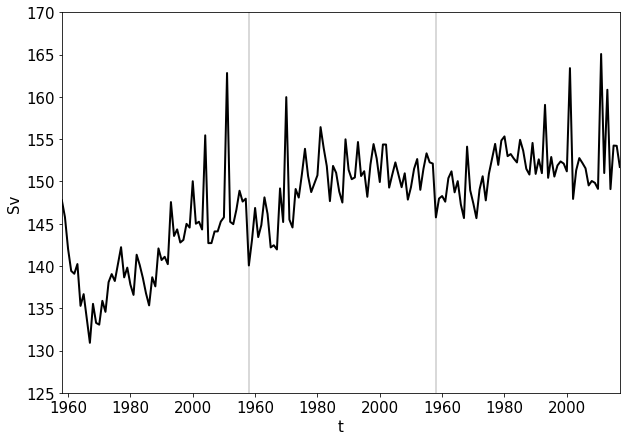

In [97]:
plt.figure(figsize = (10,7))
ax = plt.subplot()
# ax.plot(DPT_c1.year, DPT_c1.values, 'c', linewidth = 2)
# ax.plot(DPT_c2.year, DPT_c2.values, 'b', linewidth = 2)
# ax.plot(DPT_c3.year, DPT_c3.values, 'r', linewidth = 2)
ax.plot(DPT_all.year, DPT_all.values, 'k', linewidth = 2)
ax.plot([2018, 2018], [120,170], 'k', alpha = 0.2)
ax.plot([2078, 2078], [120,170], 'k', alpha = 0.2)
ax.set_ylim([125,170])
ax.set_xlim([1958,2137])
xticks = np.array([1960,1980,2000,2020,2040,2060,2080,2100,2120])
ax.set_xticks(xticks)
xticks = np.array([1960,1980,2000,1960,1980,2000,1960,1980,2000])
ax.set_xticklabels(xticks)
ax.set_ylabel('Sv')
ax.set_xlabel('t')

plt.show()

In [123]:
# each cycle full and satellite era time mean contour
# full time mean (c1)
umo_2d_mean_c1 = umo_2d_C1.mean(dim = 'time')
contour_numbered, contour_mask, psi_acc, contour = OM4_ACCS_psig_contour(umo_2d_mean_c1,lat_north = -29)
contour_numbered.attrs['time_avg_info']  = '1958-2017 mean umo_2D used'
contour_mask.attrs['time_avg_info']  = '1958-2017 mean umo_2D used'
contour_numbered.attrs['contour_value'] = str(contour)[:7]+' Sv'
contour_mask.attrs['contour_value'] = str(contour)[:7]+' Sv'
ds = xr.Dataset({'contour_mask_numbered':contour_numbered, 'contour_masked_south':contour_mask})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle1_1958-2017_mean_ACC_PSI_contour.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  140.83208 Sv


In [125]:
# each cycle full and satellite era time mean contour
# full time mean (c2)
umo_2d_mean_c2 = umo_2d_C2.mean(dim = 'time')
contour_numbered, contour_mask, psi_acc, contour = OM4_ACCS_psig_contour(umo_2d_mean_c2,lat_north = -29)
contour_numbered.attrs['time_avg_info']  = '1958-2017 mean umo_2D used'
contour_mask.attrs['time_avg_info']  = '1958-2017 mean umo_2D used'
contour_numbered.attrs['contour_value'] = str(contour)[:7]+' Sv'
contour_mask.attrs['contour_value'] = str(contour)[:7]+' Sv'
ds = xr.Dataset({'contour_mask_numbered':contour_numbered, 'contour_masked_south':contour_mask})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle2_1958-2017_mean_ACC_PSI_contour.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  149.49255 Sv


In [126]:
# each cycle full and satellite era time mean contour
# full time mean (c3)
umo_2d_mean_c3 = umo_2d_C3.mean(dim = 'time')
contour_numbered, contour_mask, psi_acc, contour = OM4_ACCS_psig_contour(umo_2d_mean_c3,lat_north = -29)
contour_numbered.attrs['time_avg_info']  = '1958-2017 mean umo_2D used'
contour_mask.attrs['time_avg_info']  = '1958-2017 mean umo_2D used'
contour_numbered.attrs['contour_value'] = str(contour)[:7]+' Sv'
contour_mask.attrs['contour_value'] = str(contour)[:7]+' Sv'
ds = xr.Dataset({'contour_mask_numbered':contour_numbered, 'contour_masked_south':contour_mask})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle3_1958-2017_mean_ACC_PSI_contour.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  150.79964 Sv


In [127]:
# each cycle full and satellite era time mean contour
# satellite time mean (c1)
umo_2d_mean_c1 = umo_2d_C1.sel(time = slice('1993', None)).mean(dim = 'time')
contour_numbered, contour_mask, psi_acc, contour = OM4_ACCS_psig_contour(umo_2d_mean_c1,lat_north = -29)
contour_numbered.attrs['time_avg_info']  = '1993-2017 mean umo_2D used'
contour_mask.attrs['time_avg_info']  = '1993-2017 mean umo_2D used'
contour_numbered.attrs['contour_value'] = str(contour)[:7]+' Sv'
contour_mask.attrs['contour_value'] = str(contour)[:7]+' Sv'
ds = xr.Dataset({'contour_mask_numbered':contour_numbered, 'contour_masked_south':contour_mask})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle1_1993-2017_mean_ACC_PSI_contour.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  144.44508 Sv


In [128]:
# each cycle full and satellite era time mean contour
# satellite time mean (c2)
umo_2d_mean_c2 = umo_2d_C2.sel(time = slice('1993', None)).mean(dim = 'time')
contour_numbered, contour_mask, psi_acc, contour = OM4_ACCS_psig_contour(umo_2d_mean_c2,lat_north = -29)
contour_numbered.attrs['time_avg_info']  = '1993-2017 mean umo_2D used'
contour_mask.attrs['time_avg_info']  = '1993-2017 mean umo_2D used'
contour_numbered.attrs['contour_value'] = str(contour)[:7]+' Sv'
contour_mask.attrs['contour_value'] = str(contour)[:7]+' Sv'
ds = xr.Dataset({'contour_mask_numbered':contour_numbered, 'contour_masked_south':contour_mask})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle2_1993-2017_mean_ACC_PSI_contour.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  151.41081 Sv


In [129]:
# each cycle full and satellite era time mean contour
# satellite time mean (c3)
umo_2d_mean_c3 = umo_2d_C3.sel(time = slice('1993', None)).mean(dim = 'time')
contour_numbered, contour_mask, psi_acc, contour = OM4_ACCS_psig_contour(umo_2d_mean_c3,lat_north = -29)
contour_numbered.attrs['time_avg_info']  = '1993-2017 mean umo_2D used'
contour_mask.attrs['time_avg_info']  = '1993-2017 mean umo_2D used'
contour_numbered.attrs['contour_value'] = str(contour)[:7]+' Sv'
contour_mask.attrs['contour_value'] = str(contour)[:7]+' Sv'
ds = xr.Dataset({'contour_mask_numbered':contour_numbered, 'contour_masked_south':contour_mask})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle3_1993-2017_mean_ACC_PSI_contour.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  151.10712 Sv


In [133]:
contour_mask

<xarray.DataArray (yh: 382, xq: 1440)>
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... -29.59 -29.37 -29.15
  * xq       (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
Attributes:
    time_avg_info:  1993-2017 mean umo_2D used
    contour_value:  151.107 Sv

In [134]:
ds = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle1_1993-2017_mean_ACC_PSI_contour.nc')
accpsi_mask_satmean_c1 = ds.contour_masked_south
ds = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle2_1993-2017_mean_ACC_PSI_contour.nc')
accpsi_mask_satmean_c2 = ds.contour_masked_south
ds = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle3_1993-2017_mean_ACC_PSI_contour.nc')
accpsi_mask_satmean_c3 = ds.contour_masked_south

In [135]:
ds = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle1_1958-2017_mean_ACC_PSI_contour.nc')
accpsi_mask_mean_c1 = ds.contour_masked_south
ds = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle2_1958-2017_mean_ACC_PSI_contour.nc')
accpsi_mask_mean_c2 = ds.contour_masked_south
ds = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle3_1958-2017_mean_ACC_PSI_contour.nc')
accpsi_mask_mean_c3 = ds.contour_masked_south

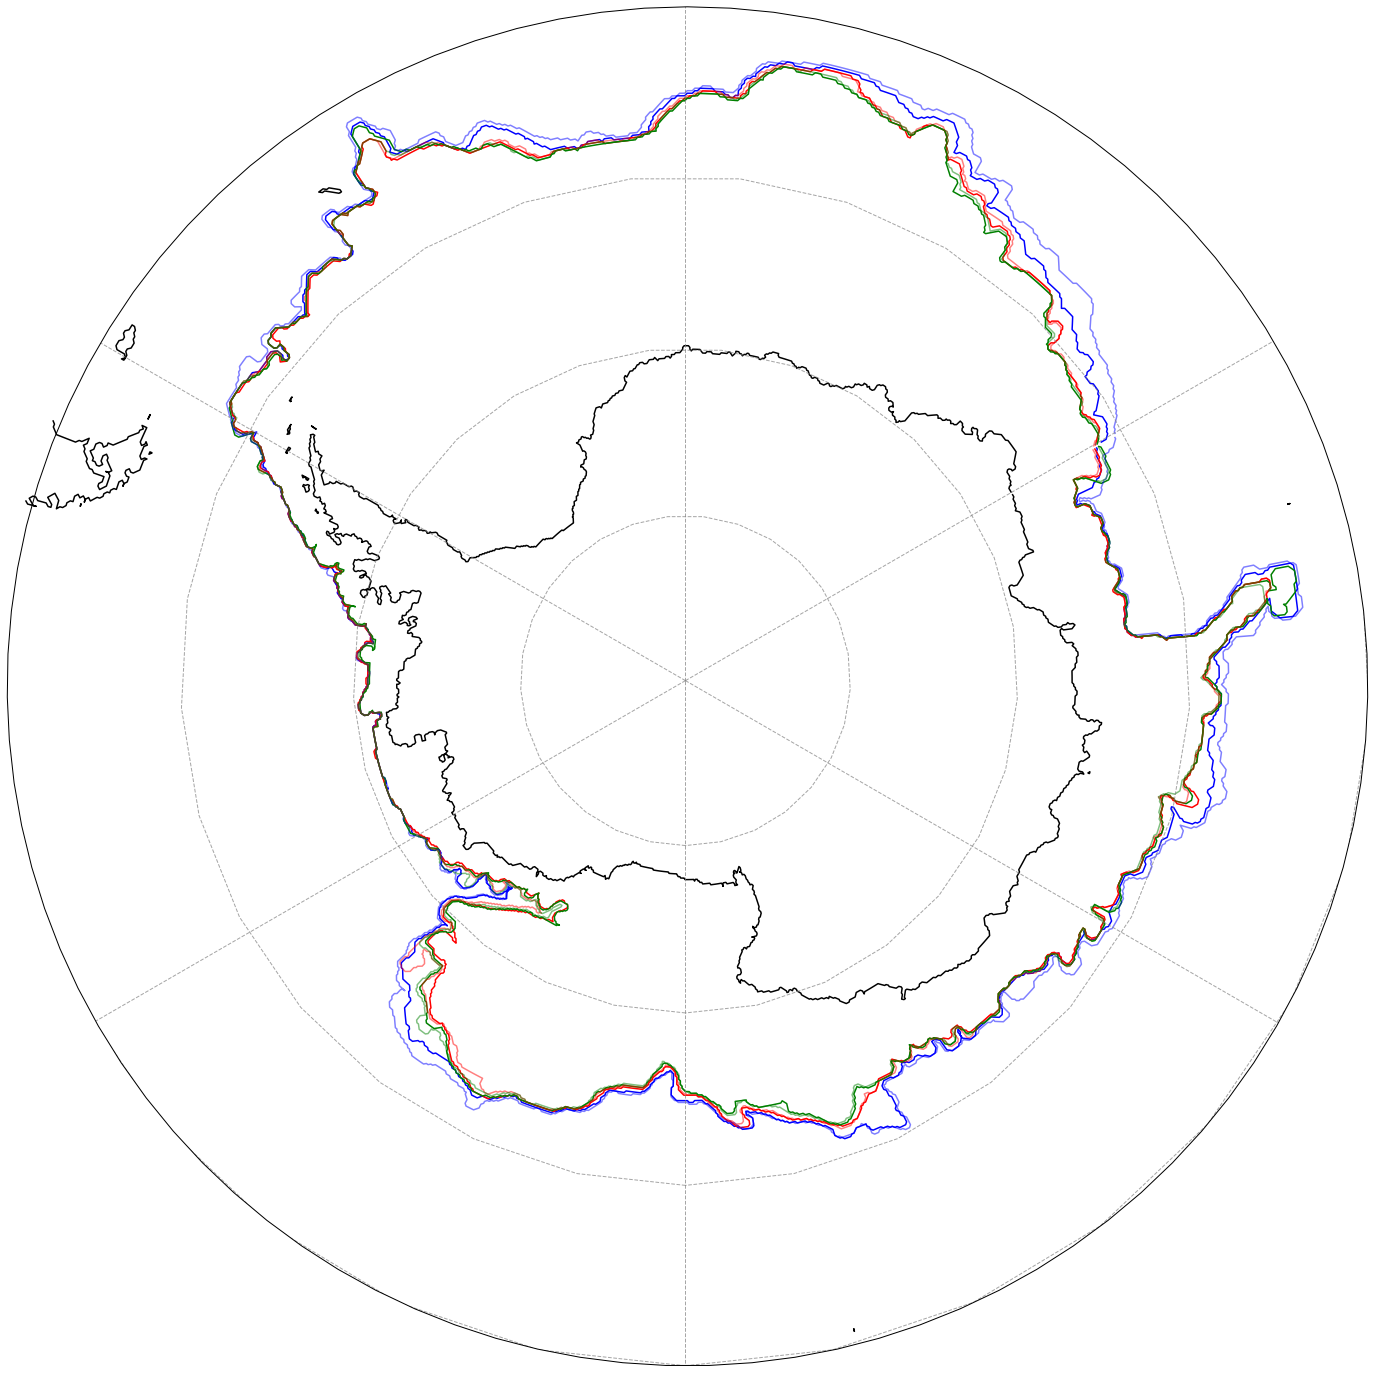

In [137]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50)
ax.contour(accpsi_mask_satmean_c1.xq, accpsi_mask_satmean_c1.yh,accpsi_mask_satmean_c1.fillna(0), levels = [0,1], colors = 'b', alpha = 1, transform = ccrs.PlateCarree())
ax.contour(accpsi_mask_satmean_c2.xq, accpsi_mask_satmean_c2.yh,accpsi_mask_satmean_c2.fillna(0), levels = [0,1], colors = 'r', alpha = 1, transform = ccrs.PlateCarree())
ax.contour(accpsi_mask_satmean_c3.xq, accpsi_mask_satmean_c3.yh,accpsi_mask_satmean_c3.fillna(0), levels = [0,1], colors = 'g', alpha = 1, transform = ccrs.PlateCarree())
ax.contour(accpsi_mask_mean_c1.xq, accpsi_mask_mean_c1.yh,accpsi_mask_mean_c1.fillna(0), levels = [0,1], colors = 'b', alpha = 0.5, transform = ccrs.PlateCarree())
ax.contour(accpsi_mask_mean_c2.xq, accpsi_mask_mean_c2.yh,accpsi_mask_mean_c2.fillna(0), levels = [0,1], colors = 'r', alpha = 0.5, transform = ccrs.PlateCarree())
ax.contour(accpsi_mask_mean_c3.xq, accpsi_mask_mean_c3.yh,accpsi_mask_mean_c3.fillna(0), levels = [0,1], colors = 'g', alpha = 0.5, transform = ccrs.PlateCarree())

plt.show()